# Проект «Промышленность»

### Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали.
Для этого комбинату нужно контролировать температуру сплава.

Задача: построить модель, которая будет её предсказывать.

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).



## Загрузка библиотек

In [1]:
import math as m
import os
import pandas as pd
import numpy as np
import shap
import phik
from matplotlib import pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import seaborn as sns
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [2]:
RANDOM_STATE=241224

In [3]:
TEST_SIZE=0.25

## Загрузка данных

In [4]:
path_an_1 = '/datasets/data_arc_new.csv'
path_an_2 = 'data_arc_new.csv'

if os.path.exists(path_an_1):
    data_an = pd.read_csv(path_an_1)
elif os.path.exists(path_an_2):
    data_an = pd.read_csv(path_an_2)
else:
    print('Нет файла с данными')

In [5]:
path_bn_1 = '/datasets/data_bulk_new.csv'
path_bn_2 = 'data_bulk_new.csv'

if os.path.exists(path_bn_1):
    data_bn = pd.read_csv(path_bn_1)
elif os.path.exists(path_bn_2):
    data_bn = pd.read_csv(path_bn_2)
else:
    print('Нет файла с данными')

In [6]:
path_btn_1 = '/datasets/data_bulk_time_new.csv'
path_btn_2 = 'data_bulk_time_new.csv'

if os.path.exists(path_btn_1):
    data_btn = pd.read_csv(path_btn_1)
elif os.path.exists(path_btn_2):
    data_btn = pd.read_csv(path_btn_2)
else:
    print('Нет файла с данными')

In [7]:
path_gn_1 = '/datasets/data_gas_new.csv'
path_gn_2 = 'data_gas_new.csv'

if os.path.exists(path_gn_1):
    data_gn = pd.read_csv(path_gn_1)
elif os.path.exists(path_gn_2):
    data_gn = pd.read_csv(path_gn_2)
else:
    print('Нет файла с данными')

In [8]:
path_tn_1 = '/datasets/data_temp_new.csv'
path_tn_2 = 'data_temp_new.csv'

if os.path.exists(path_tn_1):
    data_tn = pd.read_csv(path_tn_1)
elif os.path.exists(path_tn_2):
    data_tn = pd.read_csv(path_tn_2)
else:
    print('Нет файла с данными')

In [9]:
path_wn_1 = '/datasets/data_wire_new.csv'
path_wn_2 = 'data_wire_new.csv'

if os.path.exists(path_wn_1):
    data_wn = pd.read_csv(path_wn_1)
elif os.path.exists(path_wn_2):
    data_wn = pd.read_csv(path_wn_2)
else:
    print('Нет файла с данными')

In [10]:
path_wtn_1 = '/datasets/data_wire_time_new.csv'
path_wtn_2 = 'data_wire_time_new.csv'

if os.path.exists(path_wtn_1):
    data_wtn = pd.read_csv(path_wtn_1)
elif os.path.exists(path_wtn_2):
    data_wtn = pd.read_csv(path_wtn_2)
else:
    print('Нет файла с данными')

#### Осмотр данных

Посмотрим на датасеты

##### data_arc_new

Согласно описанию, здесь содержатся времена начала и конца нагрева, а также величины мощностей, активной и реактивной.

In [11]:
data_an.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Данные полные, без NaN'ов.
Названия столбцов не соответствуют стандартному стилю.
Видим, что тип данных для времен не соответствует необходимому (datetime).

Посмотрим на первые пять строк.

In [12]:
data_an.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Датасет загрузился корректно.

##### data_bulk_new

In [13]:
data_bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


Видим, что в данных много пропусков, что обусловлено технологией процесса.
Названия столбцов не соответствуют стандартному стилю.

Посмотрим на первые пять строк.

In [14]:
data_bn.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Датасет загрузился корректно.

##### data_bulk_time_new

In [15]:
data_btn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


Видим, что в данных много пропусков, что обусловлено технологией процесса.
Названия столбцов не соответствуют стандартному стилю.
Данный датасет смысловым образом связан с предыдущим (data_bulk_time), поэтому количество наличествующих значений в столбцах должно совпадать.
Мы видим, что так и есть, то есть, на первый взгляд, данные корректны.
Тип данных, однако, необходимо будет привести к нужному формату.

Посмотрим на первые пять строк.

In [16]:
data_btn.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Данные загрузились корректно.

##### data_gas_new

In [17]:
data_gn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Данные полные, без NaN'ов.
Название столбца не соответствует стилю.

Посмотрим на первые пять строк.

In [18]:
data_gn.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Датасет загрузился корректно.

##### data_temp_new

In [19]:
data_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Видим, что данные неполные: есть пропуски в столбце «Температура».
Необходимо дополнительно исследовать этот вопрос, т.к. если отсутствуют значения, как минимум, конечной температуры, то значения целевого признака у нас нет.

Посмотрим на первые пять строк нашего датафрейма.

In [20]:
data_tn.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Датафрейм загрузился корректно.

##### data_wire_new

In [21]:
data_wn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Данные неполные, что обусловлено технологией процесса.
Названия столбцов не соответствуют стандартному стилю.

Посмотрим на первые пять строк.

In [22]:
data_wn.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет загрузился корректно.

##### data_wire_time_new

In [23]:
data_wtn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Данные неполные, что обусловлено технологией процесса.
Названия столбцов не соответствуют стандартному стилю.

Посмотрим на первые пять строк.

In [24]:
data_wtn.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет загрузился корректно.

Загрузка данных завершена.

## Предварительная обработка данных

Приведем назваания столбцов к стандартному стилю в каждом из датасетов.

Переименуем столбцы в датасетах data_an (данные об электродах), data_tn (результаты измерения температуры) и 
data_gn (данные о продувке сплава газом).

In [25]:
data_an = data_an.rename(columns={
    'Начало нагрева дугой': 'arc_heating_begin',
    'Конец нагрева дугой': 'arc_heating_end',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power'
})

In [26]:
data_tn = data_tn.rename(columns={
    'Время замера': 'measurement_time',
    'Температура': 'temperature'
})

In [27]:
data_gn = data_gn.rename(columns={
    'Газ 1': 'gas_vol'
})

Во всех остальных датасетах приведем названия столбцов к нижнему регистру и заменим пробел нижним подчеркиванием.

In [28]:
def cast(c):
    return c.lower().replace(' ', '_')

data_bn.columns = [cast(c) for c in data_bn.columns]
data_btn.columns = [cast(c) for c in data_btn.columns]
data_wn.columns = [cast(c) for c in data_wn.columns]
data_wtn.columns = [cast(c) for c in data_wtn.columns]

Приведем во всех датасетах, где это необходимо, столбцы с датой к формату datetime

In [29]:
cols = data_an.columns[1:3]
data_an[cols] = data_an[cols].apply(pd.to_datetime)

In [30]:
cols = data_btn.columns[1:]
data_btn[cols] = data_btn[cols].apply(pd.to_datetime)

In [31]:
cols = data_wtn.columns[1:]
data_wtn[cols] = data_wtn[cols].apply(pd.to_datetime)

In [32]:
data_tn['measurement_time'] = data_tn['measurement_time'].apply(pd.to_datetime)

Преобразовали типы.
Проверим на дубликаты значений.

In [33]:
data_an.duplicated().any()

np.False_

In [34]:
data_tn.duplicated().any()

np.False_

In [35]:
data_bn.duplicated().any()

np.False_

In [36]:
data_gn.duplicated().any()

np.False_

In [37]:
data_wn.duplicated().any()

np.False_

In [38]:
data_wtn.duplicated().any()

np.False_

In [39]:
data_btn.duplicated().any()

np.False_

Дубликатов нет.

Изучим подробнее датасет data_tn (результаты измерения температуры).
Оставим только те партии, в которых есть минимум два замера — начальный и конечный — температуры и оба не равны NaN.
Кроме того, удалим также и те партии, в которых начальное (конечное) время замера не является наименьшим (наибольшим) относительно времен подачи материалов в сплав.

In [40]:
bad_keys = []
def bad_party(party, time_min, time_max):
    if party.iloc[0]['measurement_time'] >= party.iloc[-1]['measurement_time'] or \
        m.isnan(party.iloc[0]['temperature']) or \
        m.isnan(party.iloc[-1]['temperature']) or \
        party.iloc[0]['measurement_time'] >= time_min or \
        party.iloc[-1]['measurement_time'] <= time_max:
        return True

    return False
    
for key in range(1, data_tn['key'].max() + 1):
    if data_tn[data_tn['key'] == key].empty or \
       data_btn[data_btn['key'] == key].empty or \
       data_wtn[data_wtn['key'] == key].empty:
        bad_keys.append(key)
        continue

    t_data_tn = data_tn[data_tn['key'] == key].reset_index(drop=True)

    t_data_btn_min = data_btn[data_btn['key'] == key].drop('key', axis=1).min(axis=1).item()
    t_data_btn_max = data_btn[data_btn['key'] == key].drop('key', axis=1).max(axis=1).item()
    t_data_wtn_min = data_wtn[data_wtn['key'] == key].drop('key', axis=1).min(axis=1).item()
    t_data_wtn_max = data_wtn[data_wtn['key'] == key].drop('key', axis=1).max(axis=1).item()
    t_data_bwtn_min = min([t_data_btn_min, t_data_wtn_min])
    t_data_bwtn_max = max([t_data_btn_max, t_data_wtn_max])

    if bad_party(t_data_tn, t_data_bwtn_min, t_data_bwtn_max):
        bad_keys.append(key)
        continue

print(f'Доля некорректных данных: {len(bad_keys)/(data_tn.key.max()):.2%}')

Доля некорректных данных: 28.08%


Очистим данные от некорректных партий.

In [41]:
def clear_bad_keys(data):
    return data[~data['key'].isin(bad_keys)].reset_index(drop=True)

data_an = clear_bad_keys(data_an)
data_bn = clear_bad_keys(data_bn)
data_btn = clear_bad_keys(data_btn)
data_tn = clear_bad_keys(data_tn)
data_gn = clear_bad_keys(data_gn)
data_wn = clear_bad_keys(data_wn)
data_wtn = clear_bad_keys(data_wtn)

Предварительная обработка данных завершена.

## Исследовательский анализ данных

Проведем исследовательский анализ данных.

##### data_arc_new

Посмотрим на описательную статистику «активной» и «реактивной» мощностей.

In [42]:
data_an[['active_power', 'reactive_power']].describe()

,active_power,reactive_power
count,10946.000000,10946.000000
mean,0.665605,0.424555
std,0.260365,6.846216
min,0.223895,-715.479924
25%,0.468200,0.339305
50%,0.601493,0.443167
75%,0.832980,0.612356
max,1.463773,1.270284


Видим аномальное значение реактивной мощности.
Отрицательные значения реактивной мощности в теории возможны, однако в контексте нынешней задачи нет.

Посмотрим, в каких еще партиях встречаются отрицательные значения реактивной мощности.

In [43]:
data_an[data_an['key'].isin(data_an[data_an['reactive_power'] < 0]['key'])]

,key,arc_heating_begin,arc_heating_end,active_power,reactive_power
9378,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9379,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9380,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9381,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Отрицательное значение единственно в датасете и это наша аномалия.

Остальные же значения реактивной мощности в рамках той же партии выглядят вполне нормально.
Заменим это значение на среднее из этой же партии.

In [44]:
data_an.loc[9380, 'reactive_power'] = data_an[(data_an['key'] == 2116) & (data_an['reactive_power'] > 0)]['reactive_power'].mean()

Посмотрим на графическое распределение активной мощности.

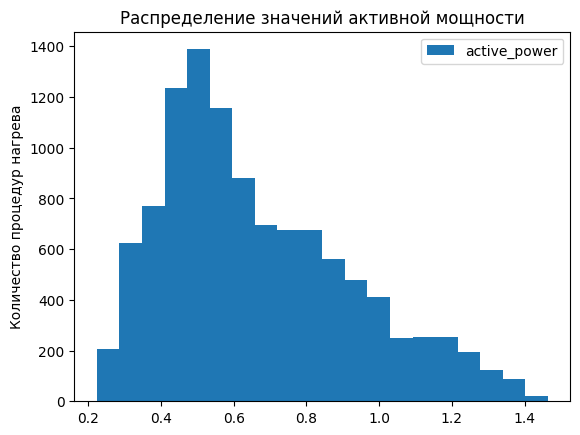

In [45]:
data_an.plot(kind='hist', bins=20, y='active_power',
             ylabel='Количество процедур нагрева',
             title='Распределение значений активной мощности');

Видим, что большинство процедур нагрева осуществлялось с активной мощностью от 0.4 до 0.6.
Распределение смещено влево.

Посмотрим на графическое распределение значений реактивной мощности.

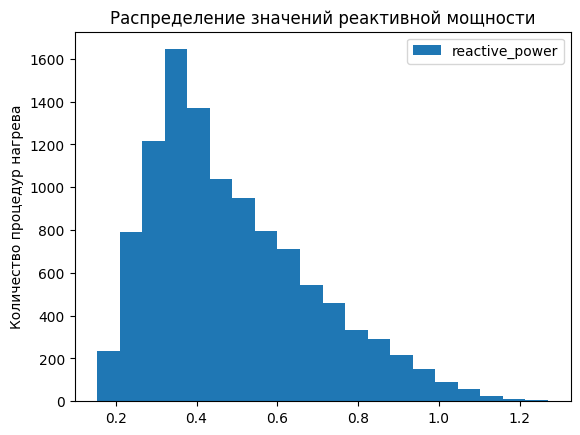

In [46]:
data_an.plot(kind='hist', bins=20, y='reactive_power',
             ylabel='Количество процедур нагрева',
             title='Распределение значений реактивной мощности');

Профили обоих распределений схожи.
Распределие также смещено влево.

##### data_bn

Рассмотрим описательную статистику данных по объему подаваемых сыпучих материалов.

In [47]:
data_bn.drop('key', axis=1).describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,199.000000,13.000000,960.000000,813.000000,53.000000,439.000000,13.000000,1.0,13.000000,143.000000,130.000000,1814.000000,14.000000,2070.000000,1701.000000
mean,40.115578,254.846154,114.868750,107.099631,116.018868,119.318907,359.153846,49.0,79.692308,82.293706,76.053846,267.757993,177.571429,173.257005,164.419165
std,18.226180,25.973853,77.485694,49.111301,95.189182,70.674754,208.804472,NaN,25.795299,27.788900,60.373554,125.584996,50.344527,63.997603,50.041008
min,10.000000,228.000000,6.000000,13.000000,11.000000,17.000000,75.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,29.000000,1.000000
25%,27.000000,242.000000,57.000000,73.000000,70.000000,72.000000,178.000000,49.0,66.000000,58.000000,25.000000,204.000000,153.250000,123.000000,105.000000
50%,33.000000,248.000000,96.500000,105.000000,88.000000,100.000000,392.000000,49.0,68.000000,85.000000,60.000000,208.000000,154.500000,153.000000,200.000000
75%,46.500000,258.000000,152.250000,137.000000,148.000000,155.500000,507.000000,49.0,71.000000,104.000000,105.500000,359.000000,158.500000,208.000000,205.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Данные вполне корректны, аномалий нет.
Видим, что материал bulk_8 использовался ровно один раз, избавимся от этого столбца.

In [48]:
data_bn = data_bn.drop('bulk_8', axis=1)
data_btn = data_btn.drop('bulk_8', axis=1)

##### data_gn

Рассмотрим описательную статистику объема подаваемого газа.

In [49]:
data_gn['gas_vol'].describe()

count    2329.000000
mean       11.375600
std         6.392041
min         0.008399
25%         7.282948
50%        10.100950
75%        14.216688
max        77.995040
Name: gas_vol, dtype: float64

Данные вполне корректны, аномалий нет.

Посмотрим на графическое распределение признака «объем подаваемого газа»

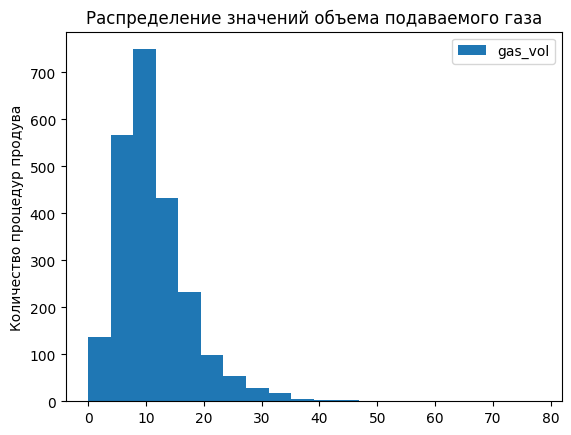

In [50]:
data_gn.plot(kind='hist', bins=20, y='gas_vol',
             ylabel='Количество процедур продува',
             title='Распределение значений объема подаваемого газа');

Видим, что в абсолютном большинстве случаев объем подаваемого газа меньше 20.

##### data_tn

Рассмотрим описательную статистику признака «значение измеренной температуры».

In [51]:
data_tn['temperature'].describe()

count    13277.000000
mean      1589.305717
std         17.572863
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1598.000000
max       1662.000000
Name: temperature, dtype: float64

Видим выбросы в виде значений температуры ниже 1400 (температура плавления стали).

Найдем все партии с такими значениями.

In [52]:
data_tn[data_tn['key'].isin(data_tn[data_tn['temperature'] < 1400]['key'])]

,key,measurement_time,temperature
4650,867,2019-06-06 08:03:39,1191.0
4651,867,2019-06-06 08:18:52,1575.0
4652,867,2019-06-06 08:22:38,1576.0
4653,867,2019-06-06 08:25:11,1571.0
4654,867,2019-06-06 08:29:49,1600.0
4655,867,2019-06-06 08:36:49,1522.0
4656,867,2019-06-06 08:43:02,1521.0
4657,867,2019-06-06 08:48:23,1599.0
6448,1214,2019-06-18 08:01:03,1208.0
6449,1214,2019-06-18 08:17:56,1608.0


Сталь в ковше должна быть расплавленной, что противоречит изначальному замеру температуры в таких партиях.
Удалим их из всех датафреймов.

In [53]:
def clear_bad_keys(data):
    return data[~data['key'].isin([867, 1214, 1619, 2052])].reset_index(drop=True)

data_an = clear_bad_keys(data_an)
data_bn = clear_bad_keys(data_bn)
data_btn = clear_bad_keys(data_btn)
data_tn = clear_bad_keys(data_tn)
data_gn = clear_bad_keys(data_gn)
data_wn = clear_bad_keys(data_wn)
data_wtn = clear_bad_keys(data_wtn)

##### data_wn

Рассмотрим описательную статистику датафрейма data_wn.

In [54]:
data_wn.drop('key', axis=1).describe()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2304.000000,809.000000,39.000000,12.000000,0.0,45.000000,4.000000,13.000000,24.000000
mean,103.422556,50.597164,193.182538,59.496235,NaN,50.659374,3.703414,55.772561,30.773167
std,42.520301,39.800935,100.867783,30.804638,NaN,37.743040,3.818433,20.235591,15.210141
min,1.918800,0.030160,0.144144,24.148801,NaN,0.137280,0.234208,45.076721,4.622800
25%,75.031317,20.180161,93.189102,38.347402,NaN,25.053600,0.849004,46.002319,20.802601
50%,102.030235,40.112801,236.972740,49.661561,NaN,40.085762,3.044704,46.187439,30.066399
75%,128.164142,70.061684,277.068801,84.755579,NaN,65.036400,5.899114,46.279999,40.495001
max,330.314424,282.780152,385.008668,113.231044,NaN,180.454575,8.490040,102.762401,62.025600


Видим, что материал «wire_5» фактически не применялся ни разу.
Его следует исключить.
В остальном, данные вполне корректны.

In [55]:
data_wn = data_wn.drop('wire_5', axis=1)
data_wtn = data_wtn.drop('wire_5', axis=1)

### Изобретение новых признаков

Для объединения датафреймов в один по ключу, для некоторых из них создадим способ агрегации содержащихся в них данных, относящихся к одной партии, но к разным ее этапам, сформировав новые признаки.

Из датафрейма data_tn начальную температуру сделаем одним из входящих признаков (под назваанием init_temp),
тогда как конечную температуру -- целевым (final_temp).
Создадим новый датафрейм с этими признаками — data_tn_new.

In [56]:
data_tn_new = {'key': [], 'init_temp': [], 'final_temp': []}
for key in data_tn['key'].unique():
    data_tn_new['key'].append(key)
    data_tn_new['init_temp'].append(data_tn.loc[data_tn['key'] == key, 'temperature'].iloc[0])
    data_tn_new['final_temp'].append(data_tn.loc[data_tn['key'] == key, 'temperature'].iloc[-1])

data_tn_new = pd.DataFrame(data_tn_new)

Посмотрим на первые пять его строк.

In [57]:
data_tn_new.head()

,key,init_temp,final_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [58]:
data_tn_new

,key,init_temp,final_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2322,2495,1570.0,1591.0
2323,2496,1554.0,1591.0
2324,2497,1571.0,1589.0
2325,2498,1591.0,1594.0


Датафрейм создан корректно.

В датафреймах, содержащих объемы подаваемых материалов, заменим NaN на 0.

In [59]:
data_bn.fillna(value=0, inplace=True)
data_gn.fillna(value=0, inplace=True)
data_wn.fillna(value=0, inplace=True)

Активную и реактивную мощности используем для расчета нового параметра — полной мощности (apparent_power), которая является их векторной суммой.
Сосчитаем полную мощность на каждом этапе нагрева, а затем сумму полных мощностей, которая и будет нашим новым признаком (sum_apparent_power)
Для оценки того, какая часть полной мощности идет на совершение полезной работы (в нашем случае — на нагрев смеси), введем новый признак —
коэффициент мощности (power_factor), т.е. отношение активной мощности к полной.
Затем сосчитаем средний коэффициент мощности для партии — это и будет еще одним новым признаком (avg_power_factor).

Время работы электродов на нагрев для разных этапов одной партии сложим (в секундах) и сформируем новый признак — суммарное время работы электрода в партии (sum_arc_heating_duration).

Обработаем датафрейм data_an, создав новые признаки, описанные выше.

In [60]:
data_an_new = {'key': [], 'sum_arc_heating_duration': [], 'sum_apparent_power': [], 'avg_power_factor': []}

for key in data_an['key'].unique():
    data_an_new['key'].append(key)
    data_an_new['sum_arc_heating_duration'].append((data_an[data_an['key'] == key]) \
                                                 .apply(lambda row: (row['arc_heating_end'] - row['arc_heating_begin']) \
                                                            .total_seconds(), axis=1).sum())
    
    apparent_power = (data_an.loc[data_an['key'] == key, ['active_power', 'reactive_power']]**2) \
                                                 .apply(lambda row: m.sqrt(row.sum()), axis=1)
    data_an_new['sum_apparent_power'].append(apparent_power.sum())
    data_an_new['avg_power_factor'].append((data_an.loc[data_an['key'] == key, 'active_power'] / apparent_power).mean())

data_an_new = pd.DataFrame(data_an_new)

Посмотрим на первые пять строк получившегося датафрейма.

In [61]:
data_an_new.head()

,key,sum_arc_heating_duration,sum_apparent_power,avg_power_factor
0,1,1098.0,3.718736,0.816686
1,2,811.0,2.588349,0.825276
2,3,655.0,5.019223,0.809724
3,4,741.0,3.400038,0.793923
4,5,869.0,2.816980,0.796818


Датафрейм сформирован.

Посмотрим на описательную статистику новых признаков.

In [62]:
data_tn_new.drop('key', axis=1).describe()

,init_temp,final_temp
count,2327.000000,2327.000000
mean,1587.363128,1593.365277
std,23.614252,11.205029
min,1519.000000,1541.000000
25%,1571.000000,1587.000000
50%,1587.000000,1593.000000
75%,1603.000000,1598.000000
max,1660.000000,1653.000000


Видим, что данные корректны, аномалий нет.

Посмотрим на графическое распределение этих признаков.

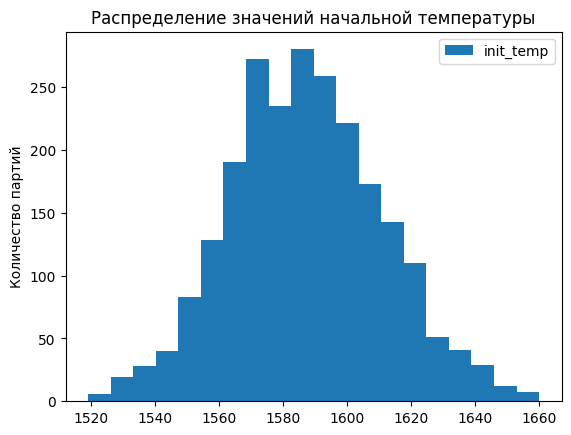

In [63]:
data_tn_new.plot(kind='hist', bins=20, y='init_temp',
             ylabel='Количество партий',
             title='Распределение значений начальной температуры');

Профиль распределения похож на нормальный с весьма пологим горбом.
Судя по всему, начальная температура стали перед процессом обработки выводится в пределы некоторого допустимого диапазона
(а не конкретную оптимальную величину).

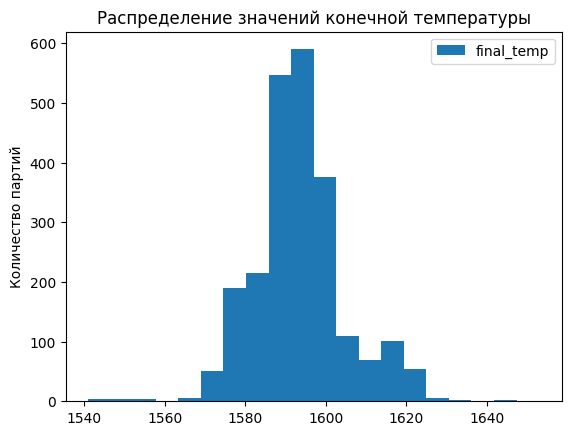

In [64]:
data_tn_new.plot(kind='hist', bins=20, y='final_temp',
             ylabel='Количество партий',
             title='Распределение значений конечной температуры');

Здесь же картина другая — явно выделяется два пика распределения.
Температура к окончанию процесса обработки выводится на некоторое оптимальное значение.

Посмотрим на описательную статистику признаков из датасета data_an_new.

In [65]:
data_an_new.drop('key', axis=1).describe()

,sum_arc_heating_duration,sum_apparent_power,avg_power_factor
count,2327.000000,2327.000000,2327.000000
mean,808.095832,3.886126,0.805484
std,340.721941,1.517169,0.013952
min,57.000000,0.331897,0.739789
25%,581.000000,2.845993,0.796798
50%,778.000000,3.769823,0.806016
75%,993.000000,4.770086,0.814813
max,4189.000000,15.288271,0.857042


Данные выглядят в целом корректными, однако бросается в глаза весьма большое максимальное значение суммарной продолжительности работы
электродов.
Посмотрим на диаграмму размаха этих признаков.

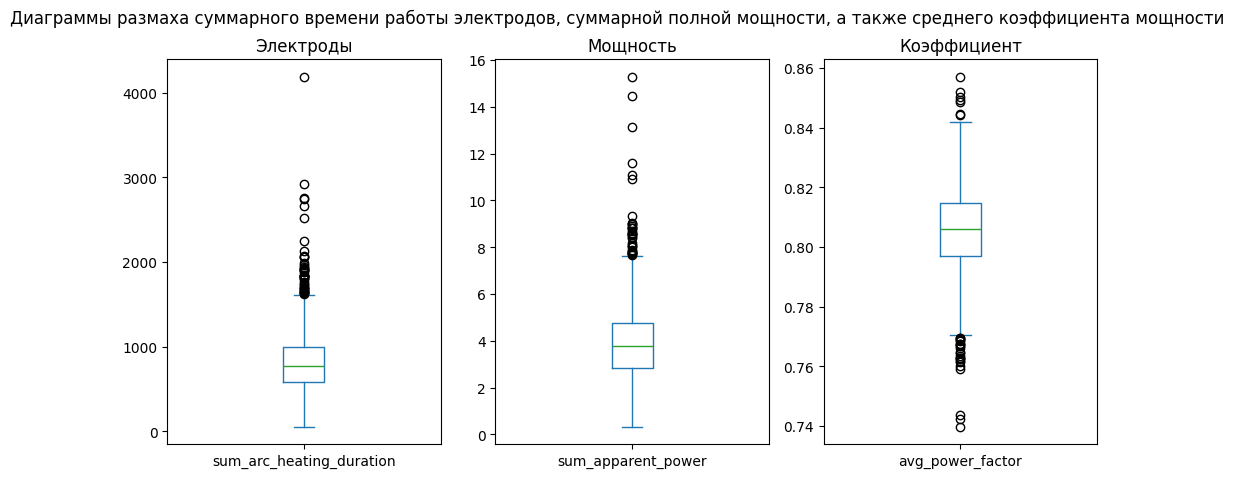

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle('Диаграммы размаха суммарного времени работы электродов, суммарной полной мощности, а также среднего коэффициента мощности')
data_an_new['sum_arc_heating_duration'].plot(ax=ax[0],kind='box', title='Электроды', ylabel='');
data_an_new['sum_apparent_power'].plot(ax=ax[1],kind='box', title='Мощность', ylabel='');
data_an_new['avg_power_factor'].plot(ax=ax[2],kind='box', title='Коэффициент', ylabel='');

Видим, что выбросы во всех распределениях есть, совсем уж аномальными они не выглядят.
Оставим как есть.

Посмотрим на графическое распределение признака sum_arc_heating_duration (суммарное время работы электродов в партии)

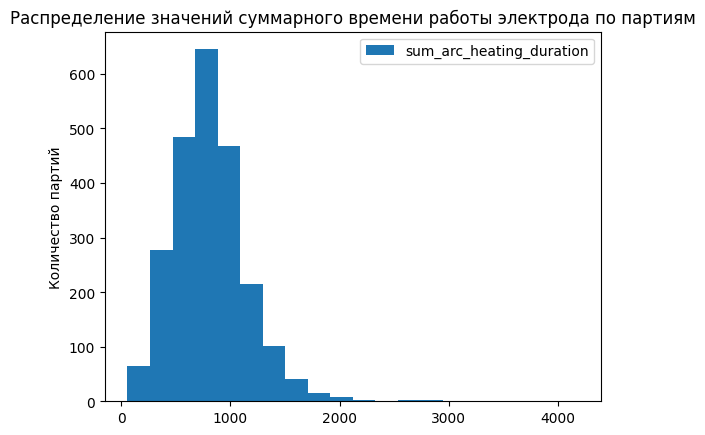

In [67]:
data_an_new.plot(kind='hist', bins=20, y='sum_arc_heating_duration',
             ylabel='Количество партий',
             title='Распределение значений суммарного времени работы электрода по партиям');

Видим, что распределение смещено влево.

Посмотрим на распределение признака sum_apparent_power (суммарная полная мощность).

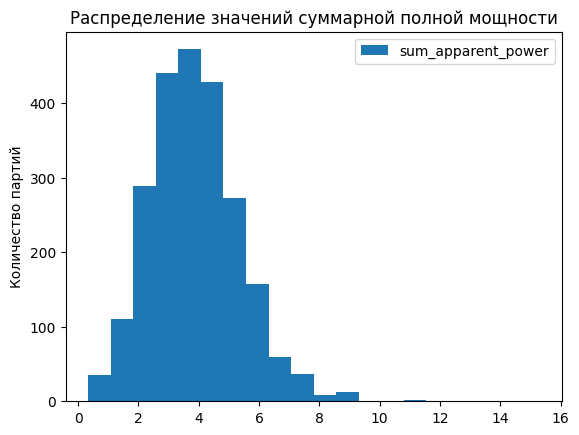

In [68]:
data_an_new.plot(kind='hist', bins=20, y='sum_apparent_power',
             ylabel='Количество партий',
             title='Распределение значений суммарной полной мощности');

Распределение также смещено влево.

Посмотрим на графическое распределение признака avg_power_factor (средний коэффициент мощности).

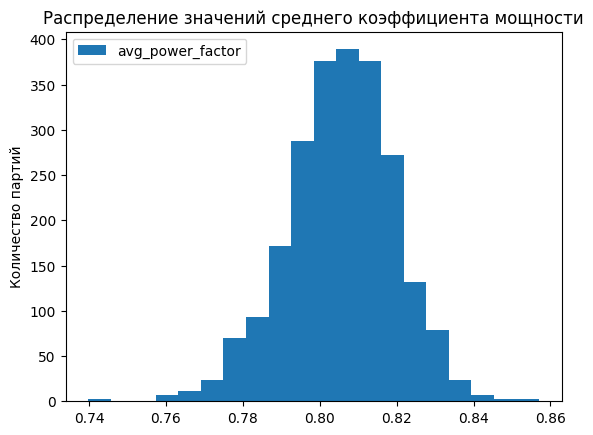

In [69]:
data_an_new.plot(kind='hist', bins=20, y='avg_power_factor',
             ylabel='Количество партий',
             title='Распределение значений среднего коэффициента мощности');

Распределение чуть смещено вправо.

### Вывод

На этапах предварительной обработки и исследования данных были численно и визуально изучены данные из загруженных датафреймов,
удалены аномалии, заполены пропуски, данные приведены в корректный вид, а также из данных некоторых датафреймов, описывающих нагрев сплава и замеры температуры сформированы новые признаки:
* суммарная полная мощность (sum_apparent_power)
* суммарное время работы электродов в секундах (sum_arc_heating_duration)
* средний коэффициент мощности (avg_power_factor)

## Объединение данных

Теперь объединим датафреймы

In [70]:
data_main = data_an_new.merge(data_bn, on='key') \
                       .merge(data_gn, on='key') \
                       .merge(data_wn, on='key') \
                       .merge(data_tn_new, on='key')

In [71]:
data_main

,key,sum_arc_heating_duration,sum_apparent_power,avg_power_factor,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,init_temp,final_temp
0,1,1098.0,3.718736,0.816686,0.0,0.0,0.0,43.0,0.0,0.0,...,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0
1,2,811.0,2.588349,0.825276,0.0,0.0,0.0,73.0,0.0,0.0,...,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0
2,3,655.0,5.019223,0.809724,0.0,0.0,0.0,34.0,0.0,0.0,...,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0
3,4,741.0,3.400038,0.793923,0.0,0.0,0.0,81.0,0.0,0.0,...,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0
4,5,869.0,2.816980,0.796818,0.0,0.0,0.0,78.0,0.0,0.0,...,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,723.0,3.868721,0.812727,0.0,0.0,21.0,0.0,0.0,0.0,...,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1591.0
2321,2496,940.0,5.070316,0.819606,0.0,0.0,0.0,63.0,0.0,0.0,...,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,1591.0
2322,2497,569.0,4.360918,0.827613,0.0,0.0,0.0,85.0,0.0,0.0,...,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1589.0
2323,2498,750.0,3.909917,0.819245,0.0,0.0,90.0,0.0,0.0,0.0,...,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1594.0


Объединенный датафрейм сформирован.

Проведем корреляционный анализ.

In [72]:
phik_overview = phik_matrix(data_main.drop('key', axis=1), interval_cols=data_main.drop('key', axis=1).columns) 

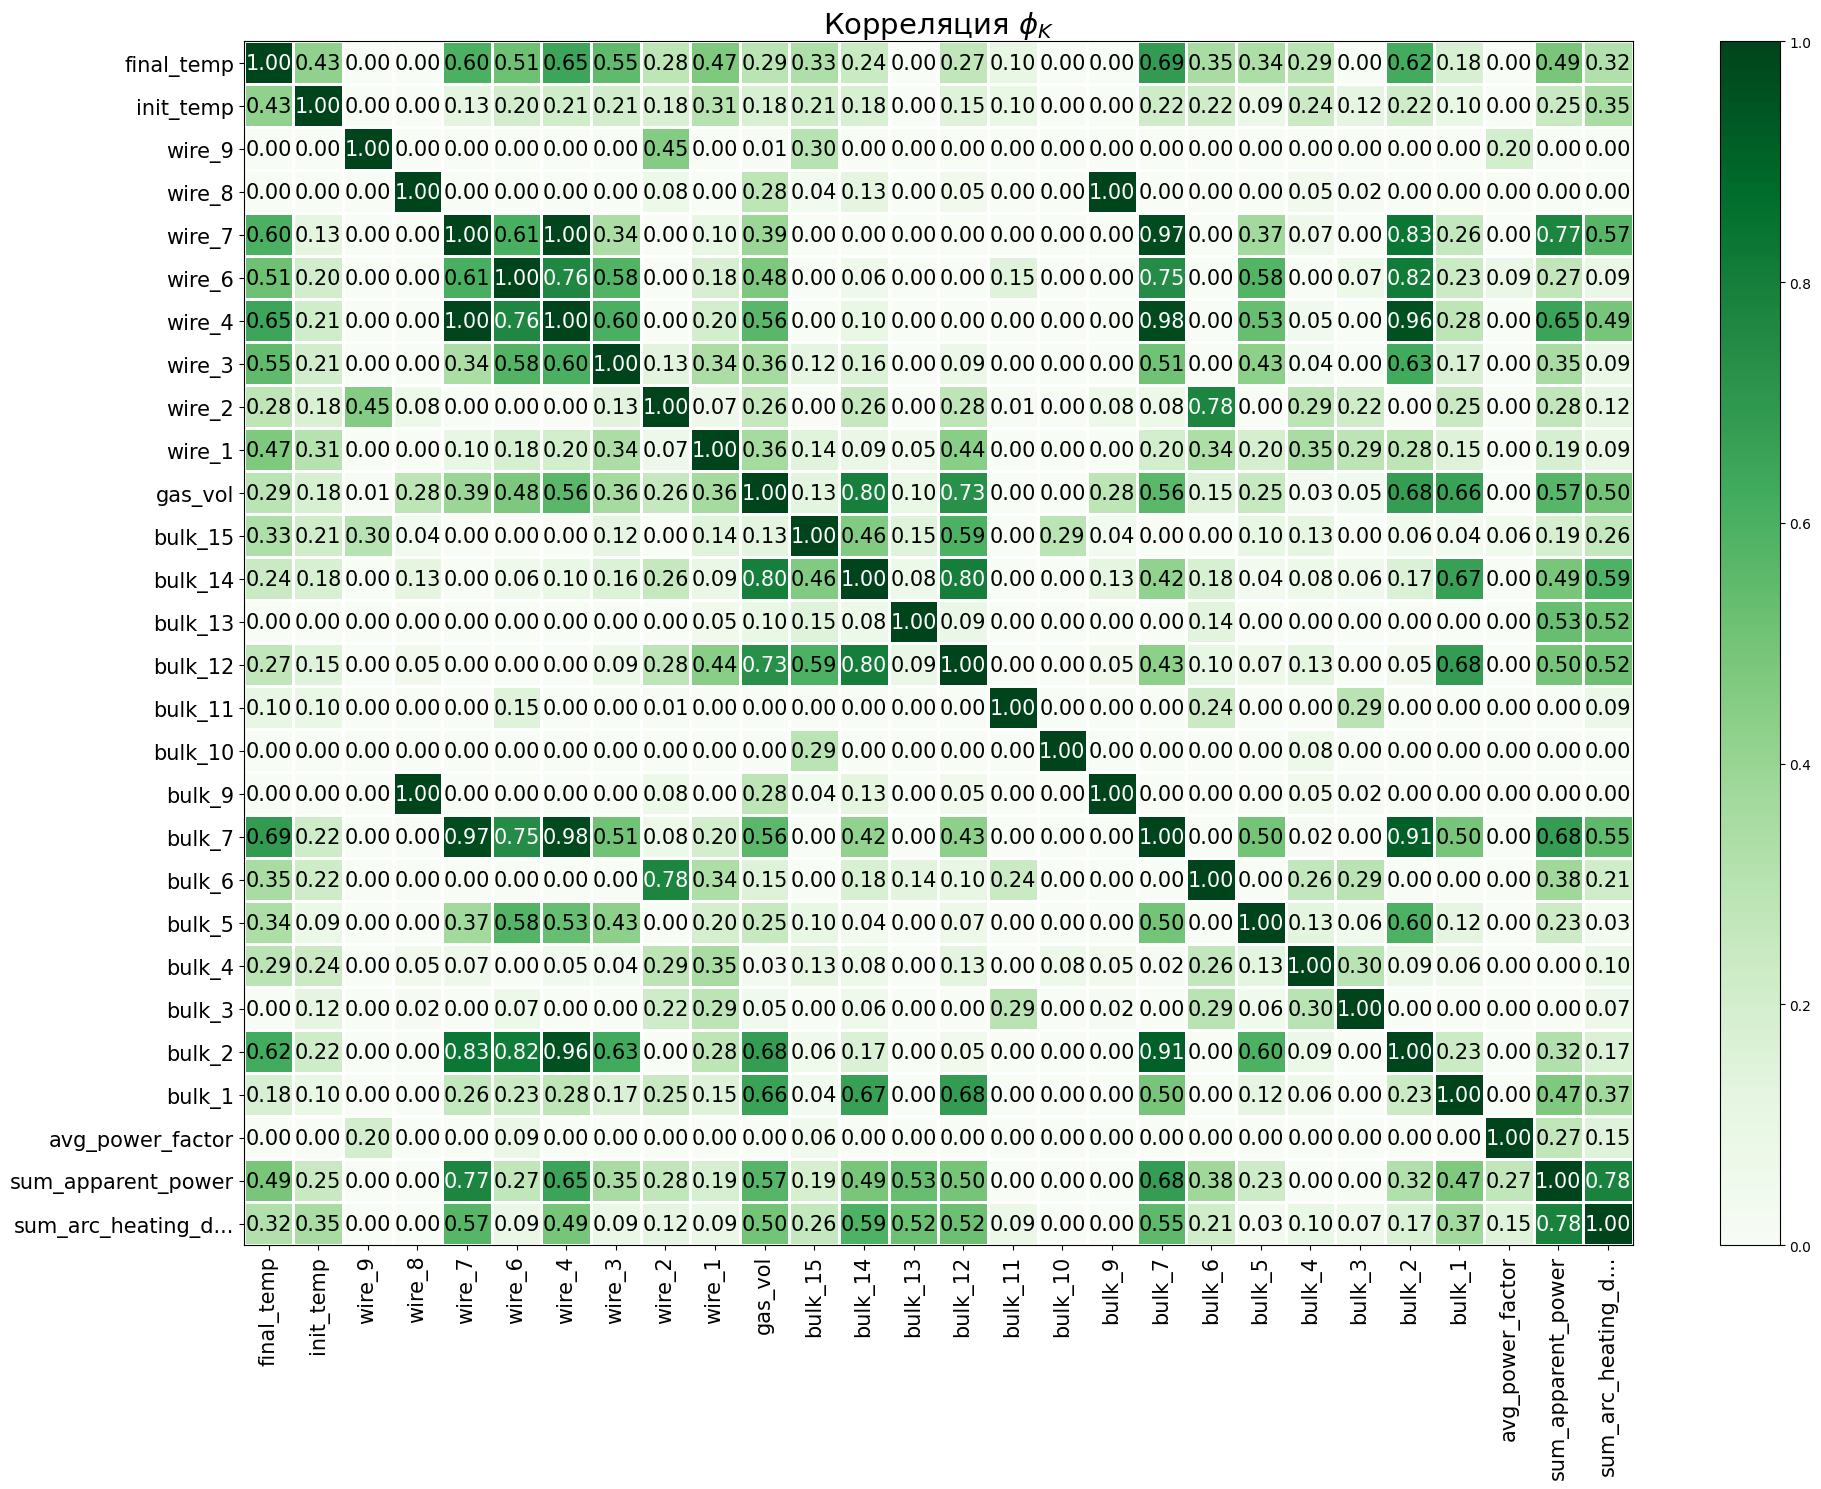

In [73]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Удалим признаки, имеющие ничтожную корреляцию с целевым (0.1 и ниже).
Кроме того, видим, что у признаков wire_4 и bulk_7 сильно выражены мультиколлинеарность с несколькими другими признаками, поэтому удалим и их тоже

In [74]:
cols_to_delete = ['wire_9', 'wire_8', 'bulk_13', 'bulk_11', 'bulk_10', 'bulk_9', 'bulk_3', 'avg_power_factor', 'wire_4', 'bulk_7']
data_main = data_main.drop(cols_to_delete, axis=1)

Построим корреляционную матрицу еще раз.

In [75]:
phik_overview = phik_matrix(data_main.drop('key', axis=1), interval_cols=data_main.drop('key', axis=1).columns)

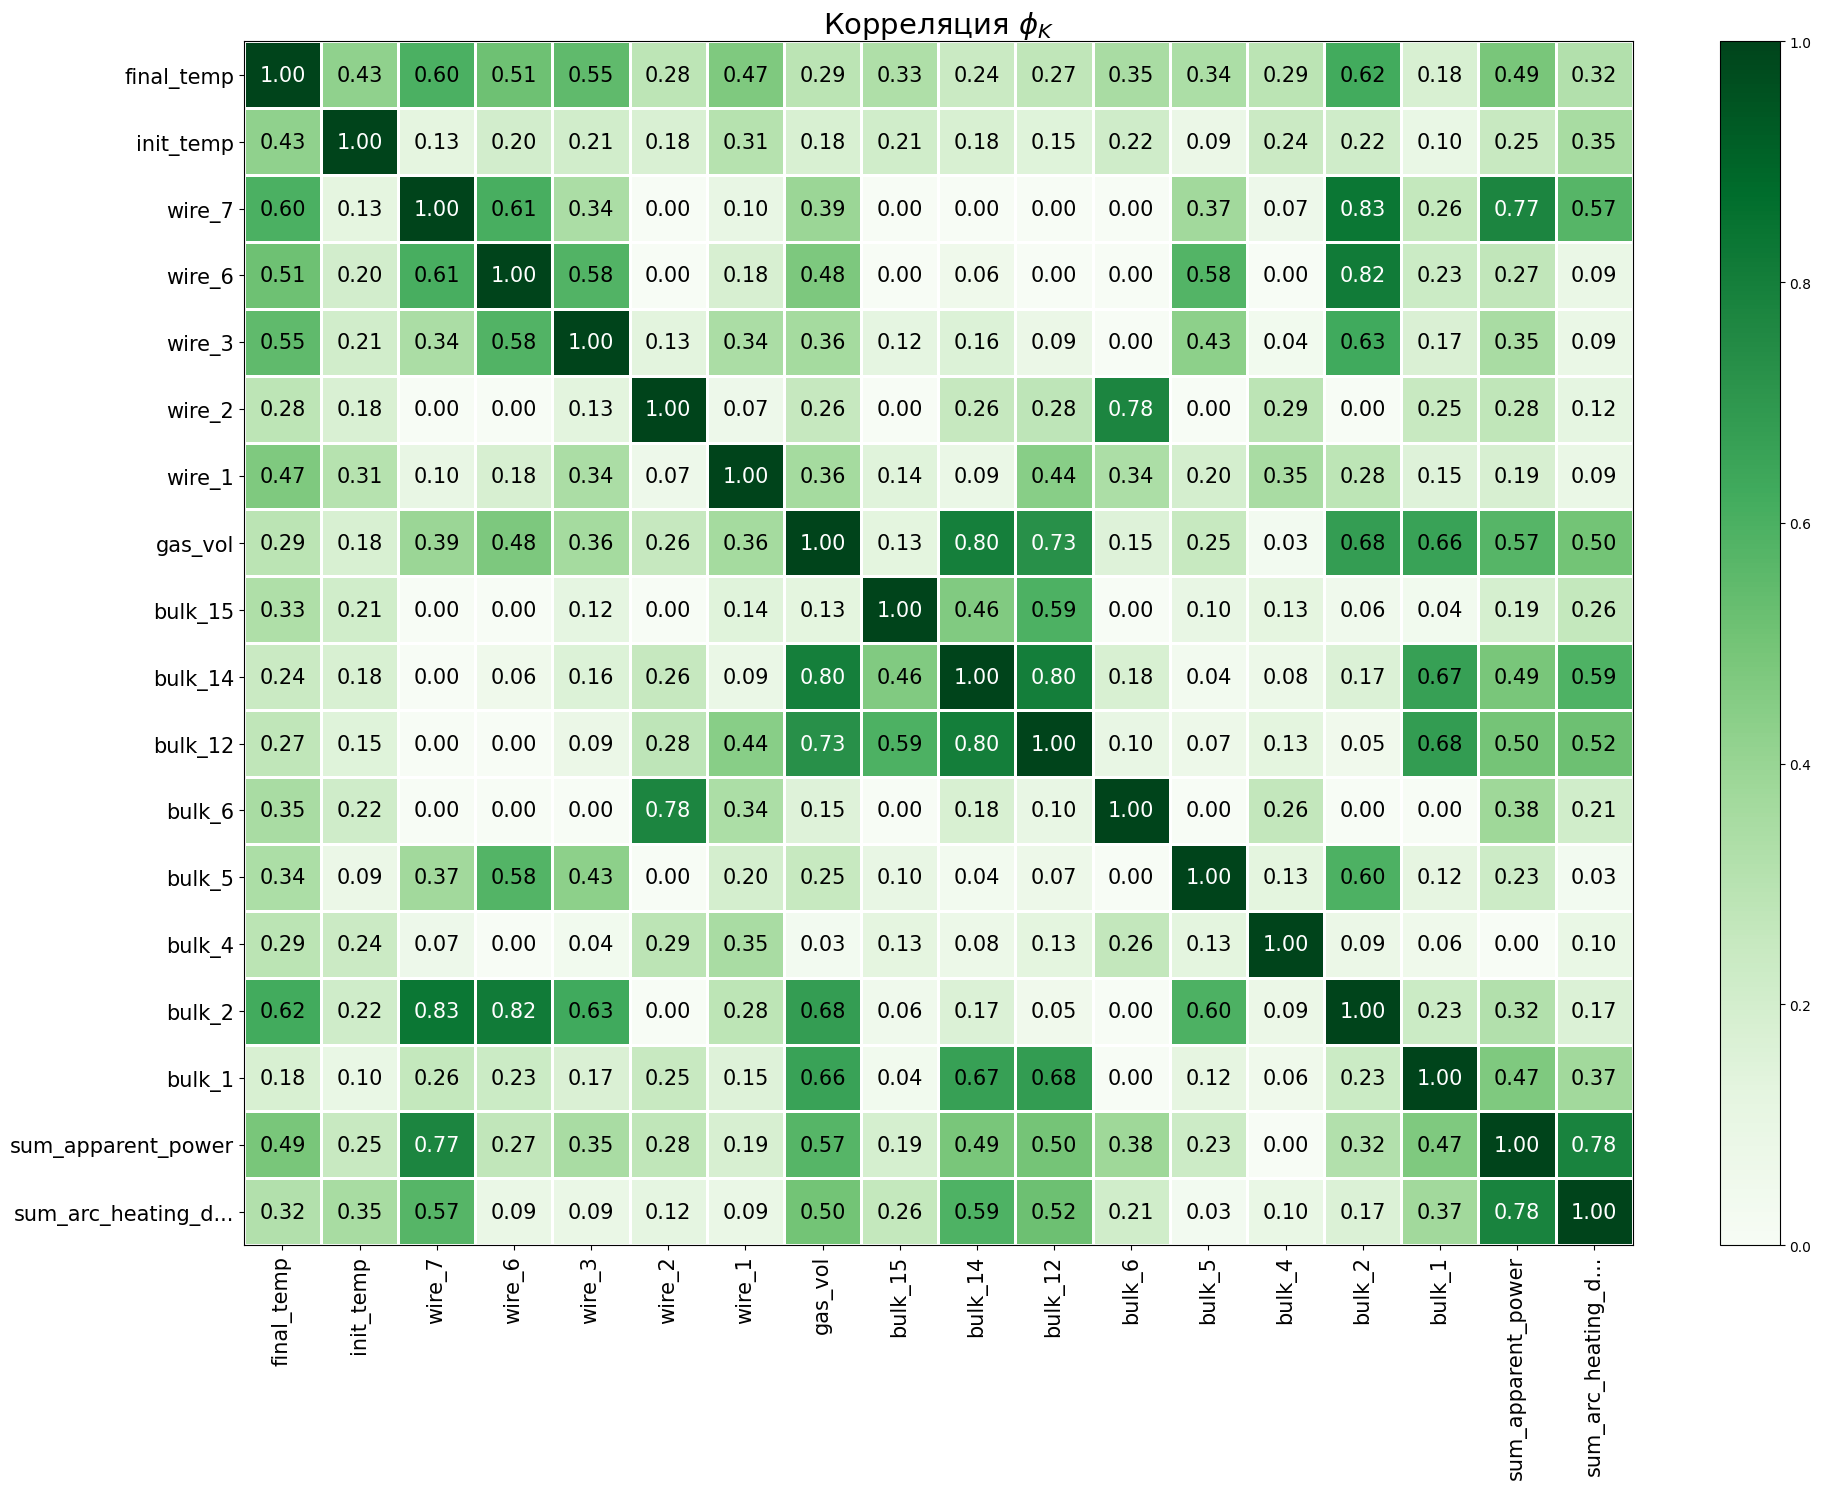

In [76]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Сильно выраженная (выше 0.9) мультиколлинеарность между признаками теперь отсутствует.
Кроме того, были удалены признаки, никак не коррелировавшие с целевым признаком.

In [77]:
data_main

,key,sum_arc_heating_duration,sum_apparent_power,bulk_1,bulk_2,bulk_4,bulk_5,bulk_6,bulk_12,bulk_14,bulk_15,gas_vol,wire_1,wire_2,wire_3,wire_6,wire_7,init_temp,final_temp
0,1,1098.0,3.718736,0.0,0.0,43.0,0.0,0.0,206.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,1571.0,1613.0
1,2,811.0,2.588349,0.0,0.0,73.0,0.0,0.0,206.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,1581.0,1602.0
2,3,655.0,5.019223,0.0,0.0,34.0,0.0,0.0,205.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,1596.0,1599.0
3,4,741.0,3.400038,0.0,0.0,81.0,0.0,0.0,207.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,1601.0,1625.0
4,5,869.0,2.816980,0.0,0.0,78.0,0.0,0.0,203.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,723.0,3.868721,0.0,0.0,0.0,0.0,0.0,256.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,1570.0,1591.0
2321,2496,940.0,5.070316,0.0,0.0,63.0,0.0,0.0,256.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,1554.0,1591.0
2322,2497,569.0,4.360918,0.0,0.0,85.0,0.0,0.0,230.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,1571.0,1589.0
2323,2498,750.0,3.909917,0.0,0.0,0.0,0.0,0.0,206.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,1591.0,1594.0


## Обучение моделей

### Подготовка выборок

In [78]:
X = data_main.drop(['key', 'final_temp'], axis=1)
y = data_main['final_temp']

Разобьем данные на тренировочную и тестовую выборки

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Случайный лес

Обучим модель случайного леса и найдем лучшие значения гиперпараметры для нее.

In [80]:
model_rforr = RandomForestRegressor()

In [81]:
params = {
    'n_estimators': range(210, 301, 10),
    'max_depth': [2, 5, 10],
    'random_state': [RANDOM_STATE]
}

In [82]:
grid_rforr = GridSearchCV(
    model_rforr,
    params,
    scoring = 'neg_mean_absolute_error'
)

In [83]:
%%time
grid_rforr.fit(X_train, y_train)
print(grid_rforr.best_params_)
print(grid_rforr.best_score_ * (-1))

/home/tokej/.local/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_depth': 10, 'n_estimators': 210, 'random_state': 241224}
6.354618906770222
CPU times: user 1min 55s, sys: 38.9 ms, total: 1min 55s
Wall time: 1min 55s


Видим хорошее значение MAE на кросс-валидации (ниже целевого порога в 6.8).
Лучшие значения гиперпараметров: n_estimators — 210, max_depth — 10.

### Линейная регрессия

Масштабируем признаки

In [84]:
scaler = StandardScaler()

In [85]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [87]:
model_lr = LinearRegression()

In [88]:
scores = cross_val_score(model_lr, X_train_scaled, y_train, scoring='neg_mean_absolute_error') * (-1)

In [89]:
mean_score = scores.mean()

In [90]:
print(f'Значение метрики MAE: {mean_score}')

Значение метрики MAE: 6.6226747163807715


Видим удовлетворительное значение MAE (ниже порогового значения), хотя и выше, чем у случайного леса.

### LightGBM

Рассмотрим модель LightGBM и найдем лучшие гиперпараметры для нее.

In [91]:
lgbm = LGBMRegressor()

Зададим гиперпараметры для нее

In [92]:
params = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 50, 70, 100],
    'random_state': [RANDOM_STATE]
}

In [93]:
grid_lgbm = GridSearchCV(
    lgbm,
    params,
    scoring = 'neg_mean_absolute_error'
)

In [94]:
%%time
grid_lgbm.fit(X_train, y_train)
print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_ * (-1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 15
[LightGBM] [Info] Start training from score 1593.512195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1891
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 15
[LightGBM] [Info] Start training from score 1593.147776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 15
[LightGBM] [Info] Start 

Видим хорошую оценку MAE (ниже порогового значения).

С точки зрения качества, то на кросс-валидации лучший MAE продемонстрировала модель LightGBM.
Выберем ее в качестве лучшей и оценим ее качество на тестовой выборке.

### Качество лучшей модели на тестовой выборке

Оценим MAE у LightGBM на тестовой выборке.

In [95]:
print(f'Значение метрики MAE на тестовой выборке: {mean_absolute_error(y_test, grid_lgbm.best_estimator_.predict(X_test))}')

Значение метрики MAE на тестовой выборке: 6.135438138167614


Качество модели удовлетворяет условию.

### Важность признаков

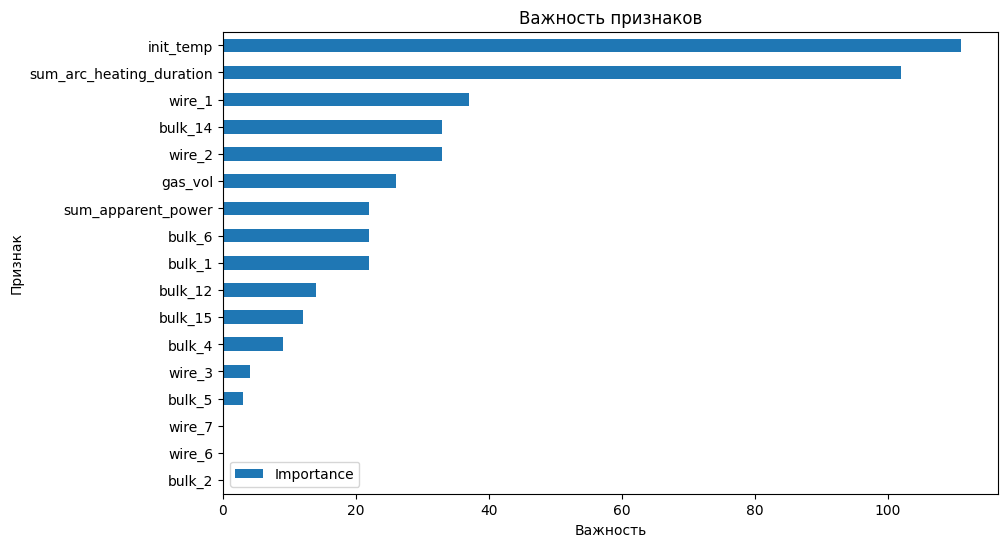

In [96]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': grid_lgbm.best_estimator_.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Важность признаков')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.show()

Самыми значимыми признаками для нашей модели оказались начальная температура (init_temp) и суммарное время работы электрода
(sum_arc_heating_duration). Также в пятерку самых значимых признаков вошли wire_1, bulk_14 и wire_2.

## Вывод

На этапе предобработки были выполнены следующие действия
* Названия столбцов приведены к соответствию стандартному стилю
* Был выбран нужный тип данных для дат.
* Изучены и приведены к корректному виду данные датафреймов.

Был выполнен исследовательский анализ данных, в ходе которого были проверены выбросы и аномальные значения в данных,
изучены и проанализированы распределения имевшихся признаков, а также сформированы и проанализированы распределения новых
изобретенных нами признаков.

Был сформирован общий датафрейм, проведен корреляционный анализ.

Были обучены 3 модели регрессии — случайный лес, линейная регрессия и LightGBM, — и найдены лучшие значения гиперпараметров этих моделей.
Лучшее значение MAE продемонстрировала модель LightGBM, которая и была выбрана в качестве наилучшей.

Проверка качества на тестовой выборке также продемонстрировала хороший результат с точки зрения целевого порога метрики MAE.

Бизнесу рекомендуется корректнее и внимательнее собирать данные для анализа, т.к. в датафреймах оказалось очень много некорректных
(несогласованных друг с другом или пустых) данных.